# Trabalho Prático 1 - Introdução à Inteligência Artificial - DCC642

### 0 - Informações básicas


- Tema: Agentes conversacionais de busca
- Professora: Gisele L. Pappa
- Aluna: Carla Beatriz Ferreira
- Data: 18/05//2025
- Valor: 15 pontos
- Documentação disponível em https://docs.google.com/document/d/1otLG8l551rNKOhsFqHR0AGeyiCqThphwiAW5-ELpzxo/edit?usp=sharing

### 1 - Configurações iniciais e impressão de dados sobre o grafo obtido

In [1]:
!pip install scikit-learn osmnx pandas matplotlib smolagents[litellm] networkx

In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from smolagents import tool, CodeAgent, LiteLLMModel, Tool, InferenceClientModel, FinalAnswerTool

c:\Users\thonl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Tal qual tutorial do Hugging Face
# from smolagents import LiteLLMModel

model = LiteLLMModel(
    model_id="ollama_chat/qwen3:8b",  # Alterado!
    api_base="http://127.0.0.1:11434",  # Default Ollama local server
    num_ctx=8192,
)

In [4]:
# G = ox.graph.graph_from_place(
#     "belo horizonte - MG", 
#     network_type="walk",
#     custom_filter='["highway"~"primary|secondary|tertiary"]'
# )
# place = "Belo Horizonte, Minas Gerais, Brazil"
# ox.save_graphml(G, filepath="bh.graphml")

# Carregando o grafo a partir do arquivo .graphml
G = ox.load_graphml("bh.graphml")
place = "Belo Horizonte, Minas Gerais, Brazil"

In [5]:
# Associa os museus aos nós do grafo
features = ox.features.features_from_place(place, {"tourism": "museum"})
feature_points = features.representative_point()
nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)

useful_tags = ["name", "fee"]  # Ajuste com base nas colunas disponíveis
for node, feature in zip(nn, features[useful_tags].to_dict(orient="records")):
    feature = {k: v for k, v in feature.items() if pd.notna(v)}
    G.nodes[node].update({"museum": feature})

In [6]:
# print(features.columns)

In [7]:
# Verifica se os museus foram associados corretamente
print(f"Quantidade de nós no grafo: {len(G.nodes)}")
print(f"Quantidade de arestas no grafo: {len(G.edges)}")
print(f"Quantidade de nós com museus: {len([n for n, d in G.nodes(data=True) if 'museum' in d])}")

Quantidade de nós no grafo: 3834
Quantidade de arestas no grafo: 11668
Quantidade de nós com museus: 14


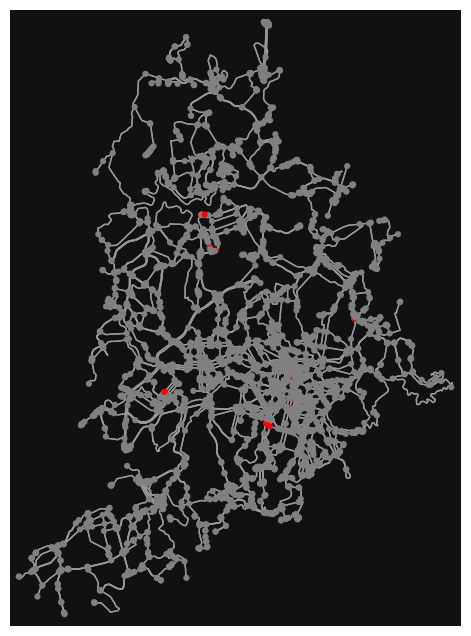

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# Identifica os nós que possuem a chave "museum"
museum_nodes = [n for n, d in G.nodes(data=True) if "museum" in d]

# Define as cores dos nós: vermelho para nós com "museum", cinza para os demais
node_colors = ["r" if n in museum_nodes else "gray" for n in G.nodes]

# Plota o grafo com as cores ajustadas
# ox.plot_graph(G, node_color=node_colors, node_size=10, edge_color="k", bgcolor="w", show=False)

# plota o grafo como no enunciado
# ox.plot_graph(G)

# Plota o grafo com os nós de museus em vermelho
node_colors = ["red" if "museum" in data else "gray" for _, data in G.nodes(data=True)]
ox.plot_graph(G, node_color=node_colors, node_size=20)

In [9]:
# Imprime os museus
for node, data in G.nodes(data=True):
    if "museum" in data:
        print(f"Node {node}: {data['museum']['name']}")

Node 27591003: Casa Kubitschek
Node 29095351: Museu de História Natural da UFMG
Node 29096783: Museu Mineiro
Node 32448895: Centro de Arte Contemporânea e Fotografia
Node 32600635: Museu de Artes e Ofícios
Node 35968129: Espaço do Conhecimento UFMG
Node 36417185: Museu da Imagem e do Som
Node 351980159: Museu de Ciências Morfológicas da UFMG
Node 1034410884: Museu de Arte da Pampulha
Node 2285761096: Museu Brasileiro do Futebol
Node 2460331365: Casarão histórico do Museu Histórico Abílio Barreto
Node 2823629282: Edificio Sede MHAB
Node 5395802458: Memorial Minas Gerais Vale
Node 8201639218: Museu de Ciências Naturais - Prédio 40


In [10]:
# imprime os museus e as ruas conectadas ao nó
for node, data in G.nodes(data=True):
    if "museum" in data:
        name = data["museum"].get("name", "Sem nome")
        ruas = set()
        for _, _, edge_data in G.edges(node, data=True):
            rua = edge_data.get("name")
            if isinstance(rua, list):
                ruas.update(rua)
            elif rua:
                ruas.add(rua)
        if ruas:
            ruas_str = " com ".join(ruas)
        else:
            ruas_str = "Rua não informada"
        print(f"- {name}: {ruas_str}")

- Casa Kubitschek: Avenida Otacílio Negrão de Lima
- Museu de História Natural da UFMG: Rua Gustavo da Silveira com Avenida Contagem
- Museu Mineiro: Avenida João Pinheiro com Rua dos Timbiras
- Centro de Arte Contemporânea e Fotografia: Avenida Afonso Pena com Avenida Amazonas
- Museu de Artes e Ofícios: Rua dos Guaicurus com Avenida dos Andradas
- Espaço do Conhecimento UFMG: Rua da Bahia com Avenida Bias Fortes
- Museu da Imagem e do Som: Avenida Álvares Cabral com Rua dos Timbiras
- Museu de Ciências Morfológicas da UFMG: Avenida Presidente Carlos Luz com Avenida Rei Pelé
- Museu de Arte da Pampulha: Avenida Otacílio Negrão de Lima
- Museu Brasileiro do Futebol: Avenida Coronel Oscar Paschoal
- Casarão histórico do Museu Histórico Abílio Barreto: Rua Conde de Linhares
- Edificio Sede MHAB: Avenida Prudente de Morais com Rua Tenente Renato César
- Memorial Minas Gerais Vale: Rua Gonçalves Dias com Praça da Liberdade
- Museu de Ciências Naturais - Prédio 40: Avenida Dom José Gaspar


### 2 - Algoritmos de busca

usando a biblioteca networkx 
- A mesma já possui funções como bfs_edges(), dfs_edges(), dijkstra_path() e astar_path()

Referências:
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html#networkx.algorithms.shortest_paths.weighted.dijkstra_path
- https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path 

In [11]:
# Custo uniforme / Dijkstra no grafo utilizando networkx
# Comentários em inglês para manter a consistência com o código original e melhor entendimento do agente

@tool
def path_with_dijkstra(
    start: str, 
    end: str, 
    G: nx.MultiDiGraph, 
    # weight: str = "length"
) -> list:
    """
    Find the shortest path between two nodes using Dijkstra's algorithm.
    
    Args:
        start (str): ID from the start node.
        end (str): ID from the end node.
        G (ox.Graph): Graph to be used.
        weight (str): Atribut to be used as weight on the edges. Default is "length".
    
    Returns:
        list: List of nodes representing the shortest path. If the path is not found, returns an empty list.
    """
    return nx.dijkstra_path(G, start, end)

In [12]:
# Definição da Heuristica para o A* como sendo o trajeto em linha reta
def heuristic(a, b):
    """
    Heuristic function for A* algorithm. It calculates the straight-line distance between two nodes.
    
    Args:
        a (str): ID from the start node.
        b (str): ID from the end node.
    
    Returns:
        float: Straight-line distance between nodes a and b.
    """
    # Calculate the straight-line distance between two nodes using their latitude and longitude
    return ox.distance.euclidean(G.nodes[a]["y"], G.nodes[a]["x"], G.nodes[b]["y"], G.nodes[b]["x"])

# Algoritimo A* utilizando networkx
@tool
def path_with_astar(
    start: str, 
    end: str, 
    G: nx.MultiDiGraph, 
    # weight: str = "length"
) -> list:
    """
    Find the shortest path between two nodes using A* algorithm.
    
    Args:
        start (str): ID from the start node.
        end (str): ID from the end node.
        G (ox.Graph): Graph to be used.
        weight (str): Atribut to be used as weight on the edges. Default is "length".
    
    Returns:
        list: List of nodes representing the shortest path. If the path is not found, returns an empty list.
    """
    return nx.astar_path(G, start, end, heuristic=heuristic)

In [ ]:
@tool
def path_with_dfs(
    start: str, 
    end: str, 
    G: object, 
    path: list = None, 
    visited: set = None
) -> list:
    """
    Find a path between two nodes using DFS algorithm (implemented manually).
    
    Args:
        start (str): ID from the start node.
        end (str): ID from the end node.
        G (object): Graph to be used.
        path (list): Current path (for recursion).
        visited (set): Set of visited nodes (for recursion).
    
    Returns:
        list: List of nodes representing a path found by DFS. If the path is not found, returns an empty list.
    """
    if path is None:
        path = [start]
    if visited is None:
        visited = set()
    visited.add(start)
    if start == end:
        return path
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            result = path_with_dfs(neighbor, end, G, path + [neighbor], visited)
            if result:
                return result
    return []

### 3 - Exemplo de conexão do agente com nosso código e LLM Ollama
Essa seção apenas apresenta código comentado que foi utilizado como base para a construção dessa atividade.

Em cada parte listada há a fonte de onde foi retirado. Dessa forma, as celulas abaixo podem ser desconsideradas para a avaliação final considerando apenas a documentação e as referências.

#### 3.1 - Uso tal qual no exemplo do vídeo do (monitor) Matheus C. Teixeira
- em https://www.youtube.com/watch?v=5PgA2StGntQ

In [14]:
# from smolagents import CodeAgent, LiteLLMModel, Tool, InferenceClientModel, FinalAnswerTool

# class FindRoutTool(Tool):
#     name = "find_route"
#     description = """
#     This tool must be used when you want to find the route or path between two places, locations or points
#     """
#     inputs = {
#         "source": {
#             "type": "string",
#             "description": "The source location. It can be an address, a place, a street name, etc.",
#         },
#         "target": {
#             "type": "string",
#             "description": "The target location. It can be an address, a place, a street name, etc.",
#         },
#     }
#     output_type = "string"

#     def forward(self, source, target):
#         return f"The sortest route from {source} to {target} is ..." #chamar a função de rota aqui
    
# model = LiteLLMModel(
#     model_id="ollama_chat/qwen3:8b",  # Or try other Ollama-supported models
#     api_base="http://localhost:11434",  # Default Ollama local server
#     num_ctx=8192,
# )

# agent = CodeAgent(tools=[FindRoutTool()], model=model, add_base_tools=False)
# agent.run("How can I go from Margô Drinkeria to Serilla Cozinha & Drinks?") #prompt a ser alterado para exemplos

#### 3.2 - Exemplo de Prompt do curso do HF
- em https://huggingface.co/learn/agents-course/unit1/dummy-agent-library

In [15]:
# # This system prompt is a bit more complex and actually contains the function description already appended.
# # Here we suppose that the textual description of the tools has already been appended.

# SYSTEM_PROMPT = """Answer the following questions as best you can. You have access to the following tools:

# get_weather: Get the current weather in a given location

# The way you use the tools is by specifying a json blob.
# Specifically, this json should have an `action` key (with the name of the tool to use) and an `action_input` key (with the input to the tool going here).

# The only values that should be in the "action" field are:
# get_weather: Get the current weather in a given location, args: {"location": {"type": "string"}}
# example use :

# {{
#   "action": "get_weather",
#   "action_input": {"location": "New York"}
# }}


# ALWAYS use the following format:

# Question: the input question you must answer
# Thought: you should always think about one action to take. Only one action at a time in this format:
# Action:

# $JSON_BLOB (inside markdown cell)

# Observation: the result of the action. This Observation is unique, complete, and the source of truth.
# ... (this Thought/Action/Observation can repeat N times, you should take several steps when needed. The $JSON_BLOB must be formatted as markdown and only use a SINGLE action at a time.)

# You must always end your output with the following format:

# Thought: I now know the final answer
# Final Answer: the final answer to the original input question

# Now begin! Reminder to ALWAYS use the exact characters `Final Answer:` when you provide a definitive answer. """

In [16]:
# # Since we are running the “text_generation” method, we need to apply the prompt manually:
# prompt=f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
# {SYSTEM_PROMPT}
# <|eot_id|><|start_header_id|>user<|end_header_id|>
# What's the weather in London ?
# <|eot_id|><|start_header_id|>assistant<|end_header_id|>
# """

# # We can also do it like this, which is what happens inside the chat method :
# messages=[
#     {"role": "system", "content": SYSTEM_PROMPT},
#     {"role": "user", "content": "What's the weather in London ?"},
#     ]
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.3-70B-Instruct")

# tokenizer.apply_chat_template(messages, tokenize=False,add_generation_prompt=True)

### 4 - Definições necessárias para o agente
Informações sobre o que ele pode usar, como mostrar a resposta final etc.

##### Opção utilizando @Tools
não utilizada!

In [17]:
# Problema: O agente não tem o direcionamento de qual função usar, então ele não consegue fazer a chamada correta.
# agent = CodeAgent(
#     tools=[
#         Tool(
#             name="path_with_dijkstra",
#             func=path_with_dijkstra,
#             description="Find the shortest path between two nodes using Dijkstra's algorithm.",
#         ),
#         Tool(
#             name="path_with_astar",
#             func=path_with_astar,
#             description="Find the shortest path between two nodes using A* algorithm.",
#         ),
#     ],
#     model=model,
#     add_base_tools=False,
# )

##### Opção utilizando uma classe FindRoutTool
Tal qual exemplo 1

In [18]:
# adicional possível: verificar se há rota com has_path() de networkx

def get_node_by_museum_name(G, museum_name):
    for node, data in G.nodes(data=True):
        if "museum" in data and data["museum"].get("name") == museum_name:
            return node
    raise ValueError(f"Museu '{museum_name}' não encontrado no grafo.")

class FindRoutTool(Tool):
    name = "find_route"
    description = """
    This tool must be used when you want to find the route or path between two places, locations or points
    """
    inputs = {
        "source": {
            "type": "string",
            "description": "The source location (museum name).",
        },
        "target": {
            "type": "string",
            "description": "The target location (museum name).",
        },
    }
    output_type = "string"

    def __init__(self, G):
        super().__init__()
        self.G = G

    def get_node_by_museum_name(self, museum_name):
        for node, data in self.G.nodes(data=True):
            if "museum" in data and data["museum"].get("name") == museum_name:
                return node
        raise ValueError(f"Museu '{museum_name}' não encontrado no grafo.")

    def forward(self, source, target):
        source_node = self.get_node_by_museum_name(source)
        target_node = self.get_node_by_museum_name(target)
        path = path_with_dfs(source_node, target_node, self.G) # or path_with_astar(source_node, target_node, self.G)
        return f"The shortest route from {source} to {target} is {path} and has {len(path)} nodes."
  
model = LiteLLMModel(
    model_id="ollama_chat/qwen3:8b",  # Or try other Ollama-supported models
    api_base="http://localhost:11434",  # Default Ollama local server
    num_ctx=8192,
)

agent = CodeAgent(tools=[FindRoutTool(G)], model=model, add_base_tools=False)

### 5 - Execução do agente
A partir do texto do "usuário" (modificando o código)

In [19]:
# Museus utilizados para os testes e avaliações
m1 = "Museu de História Natural da UFMG"
m2 = "Museu de Ciências Morfológicas da UFMG"
m3 = "Centro de Arte Contemporânea e Fotografia"
m4 = "Museu da Imagem e do Som"
m5 = "Museu de Arte da Pampulha"
m6 = "Museu de Ciências Naturais"
m7 = "Casa Kubitschek"

# print(f"How can I go from {m1} to {m2}?")

Testes Realizados:
1. De: Museu de História Natural da UFMG, Para: Museu de Ciências Morfológicas da UFMG (1 para 2)
2. De: Centro de Arte Contemporânea e Fotografia, Para: Museu da Imagem e do Som (3 para 4)
3. De: Museu de Ciências Morfológicas da UFMG, Para: Museu de Arte da Pampulha (2 para 5)


In [20]:
# Executa o agente e salva a resposta em um arquivo
with open("resposta_agente_dfs.txt", "w", encoding="utf-8") as f:
    f.write("RESPOSTAS DO AGENTE UTILIZANDO O ALGORITMO DE DFS\n")

final_answer = agent.run(f"How can I go from {m1} to {m2}")
with open("resposta_agente_dfs.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")

final_answer = agent.run(f"How can I go from {m3} to {m4}")
with open("resposta_agente_dfs.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")

final_answer = agent.run(f"How can I go from {m2} to {m5}")
with open("resposta_agente_dfs.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Museu de História Natural da UFMG", target="Museu de Ciências Morfológicas da UFMG")  
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da 
UFMG is [29095351, 8951975509, 9048339273, 8996493468, 8952002417, 8952002418, 6370080464, 303343655, 1494808236, 
1494808222, 6429380808, 5871125830, 5871125821, 6422603543, 3700274569, 3700274578, 5254923079, 6757894766, 
5254923052, 5254923046, 5290755055, 3700274611, 5254923068, 29096718, 8951580406, 8927813377, 303343268, 
1818397153, 297111794, 255615816, 29964242, 27558632, 60469555, 29649769, 29649782, 1469991202, 1469991204, 
29649811, 27563856, 2941234101, 31563879, 31563876, 78096598, 73564056, 73563991, 73564003, 73563919, 29095244, 
73563203, 73563069, 73563076, 73563085, 28384287, 2618789340, 29096517, 4270844943, 27591802, 60749858, 4634496627,
28294407, 10603799270, 10603819353, 4635986228, 30100160, 29096300, 1307102929, 2315416382, 2932149814, 29173850, 
28328657, 60672202, 30064172, 1307102966, 5059464291, 1307102917, 60739815, 29850055, 2315416386, 5059489659, 
8942238460, 29741086, 35789336, 2315423570, 28294403, 1915755329, 28109285, 8920367776, 28109263, 8920367777, 
29160780, 2827399643, 29096813, 35788222, 32600635, 29095385, 4893037817, 4893037820, 28109281, 31737028, 28109282,
31737030, 7283231730, 27584879, 29096738, 29160773, 29160775, 5090085494, 1273195041, 2848114002, 2907898701, 
28794444, 3842430994, 29161231, 5557715118, 6269325069, 5557715106, 5557715095, 321050062, 30064173, 321050092, 
3039366634, 3039400037, 2684142546, 29096564, 35930993, 29095724, 32448876, 32448875, 32448873, 32448886, 
12195305759, 32448889, 12195305763, 324773722, 2828780501, 29095105, 29095210, 35927086, 35927085, 29095247, 
32449487, 2391355820, 8272733823, 8272733824, 8272733828, 5462242773, 32449482, 32449481, 32448895, 32448893, 
32448879, 32448881, 32449478, 2590376322, 2992467334, 2845291901, 2845292201, 5441037124, 1273201210, 29160545, 
2618540179, 2618540183, 31829648, 61785366, 2296385387, 61785370, 34992673, 34992674, 34992675, 60317929, 
2563404305, 27685687, 31890021, 31890025, 61818409, 31890006, 27685679, 34992666, 34992671, 34992670, 64906858, 
50921298, 61818396, 61818393, 61818390, 34060232, 29649859, 29649862, 30064125, 8239235963, 8239235962, 61821643, 
6323656155, 61818577, 61818352, 61818360, 61818569, 64907484, 2388223556, 31736774, 1876684368, 61818329, 31563874,
61818321, 61818316, 62994490, 62994454, 62994464, 62994502, 62994563, 3271155518, 2309755223, 316994923, 
2309531853, 2309531869, 3374685796, 2958847033, 2309521858, 61821546, 2279592750, 2279592753, 27685706, 4529894152,
35763630, 35763565, 35763629, 35927170, 5209322507, 35761785, 32448869, 324773984, 993654857, 28635039, 35968161, 
35968163, 993654844, 28800979, 29096535, 35927090, 35968158, 28801012, 35968156, 50923643, 41416519, 41416532, 
41416540, 41416552, 8923642582, 8923642587, 60649278, 2826716901, 28794416, 60649421, 2843893901, 2843894001, 
8726135921, 8726135922, 8726135919, 8726135920, 12142917299, 12195322737, 10250743898, 10250743897, 10250743896, 
10250743899, 60649305, 36418257, 8933499919, 8933499924, 8933879415, 2635397508, 1996337265, 8933952992, 
2843884101, 2843884301, 8933952996, 2635443393, 8933953002, 2635443395, 8933879411, 8933499920, 8933480916, 
5372963780, 5264235251, 36417206, 36417207, 29096287, 353134395, 29095892, 36417209, 4430762761, 2310447259, 
320407423, 38428107, 35927260, 2479065018, 2460331366, 31899372, 31899385, 29096773, 2367778808, 2823629282, 
76009190, 29287966, 2823678724, 2823678729, 2823678731, 29287957, 76007242, 76007168, 76008347, 27563813, 31899404,
31899401, 27584878, 320407457, 320407480, 31899387, 2827321102, 2827321101, 2890440601, 2887576701, 8934295040, 
2890440901, 36417196, 36417193, 36417194, 36417191, 36417192, 35968155, 35968157, 28801013, 36417185, 36417184, 
36417186, 2857144601, 2941234597, 27591804, 35968129, 35968149, 8680919229, 5395802461, 5395802458, 8680919245, 
35927078, 9456218350, 5395802460, 8680919235, 8680919232, 27563817, 35966329, 32438

[Step 1: Duration 23.42 seconds| Input tokens: 2,081 | Output tokens: 338]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Centro de Arte Contemporânea e Fotografia to Museu da Imagem e do Som                         │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Centro de Arte Contemporânea e Fotografia", target="Museu da Imagem e do Som")        
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Centro de Arte Contemporânea e Fotografia to Museu da Imagem e do Som 
is [32448895, 32448893, 32448879, 32448881, 32449478, 2590376322, 2992467334, 2845291901, 2845292201, 29145511, 
29096156, 29096707, 8272982186, 32448882, 32448896, 29160780, 2827399643, 29096813, 35788222, 32600635, 29095385, 
4893037817, 4893037820, 28109281, 31737028, 28109282, 31737030, 7283231730, 27584879, 29096738, 29160773, 29160775,
5090085494, 1273195041, 2848114002, 2907898701, 28794444, 3842430994, 29161231, 5557715118, 6269325069, 5557715106,
5557715095, 321050062, 30064173, 321050092, 3039366634, 3039400037, 2684142546, 29096564, 35930993, 29095724, 
32448876, 32448875, 32448873, 32448886, 12195305759, 32448889, 12195305763, 324773722, 2828780501, 29095105, 
29095210, 35927086, 35927085, 29095247, 32449487, 2391355820, 8272733823, 8272733824, 8272733828, 5462242773, 
32449482, 2908237201, 8898863287, 8898863284, 3540576493, 8875756076, 3540576293, 8278514504, 35929907, 35929899, 
32449488, 353133245, 354123306, 12687626987, 2828756601, 3210072031, 3210072030, 29096024, 3429314500, 32449489, 
32449491, 2748450038, 35964759, 2748450035, 2748450037, 2748450045, 2748450042, 35964762, 2748450044, 35964763, 
3743536440, 3743536441, 8917055235, 35964768, 35965214, 34061774, 35965220, 2902144501, 35965208, 35964776, 
28797665, 2835788244, 32449505, 9450814327, 32449501, 32449503, 2845293501, 28797663, 2995644935, 2995641234, 
324654696, 335352466, 335352462, 335352460, 8276904318, 8276904317, 35789393, 2935578084, 5535142524, 35789390, 
2809053125, 9484003425, 28801001, 8942682081, 8917170441, 8917170439, 9484018565, 9484018555, 29096253, 35927081, 
35927078, 9456218350, 5395802460, 8680919235, 8680919232, 8680919229, 5395802461, 35968129, 27591804, 2941234597, 
2857144601, 2878237901, 2837027401, 2918622402, 29095398, 36417198, 36417194, 36417193, 36417192, 36417191, 
36417186, 36417184, 36417185] and has 165 nodes.

[Step 1: Duration 15.40 seconds| Input tokens: 2,076 | Output tokens: 269]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Museu de Ciências Morfológicas da UFMG to Museu de Arte da Pampulha                           │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Museu de Ciências Morfológicas da UFMG", target="Museu de Arte da Pampulha")          
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Museu de Ciências Morfológicas da UFMG to Museu de Arte da Pampulha is 
[351980159, 2285761114, 355770100, 31894064, 8895768709, 2285761085, 2285761096, 2285761098, 2285761111, 32137023, 
27563825, 32137026, 27590990, 322119098, 2310452553, 27590950, 2310452552, 322119113, 351981296, 4988468462, 
29096691, 8933654491, 28296527, 31882615, 355770103, 27650750, 351980331, 2965169479, 3321932723, 3321932693, 
3321924855, 3321932721, 3321924814, 27797342, 351980162, 2285761081, 32137031, 8895660558, 27563823, 2327755309, 
27563826, 2327755293, 2327755295, 28136508, 28136509, 27591007, 1034410870, 1034410858, 27591003, 27591004, 
1034410884] and has 51 nodes.

[Step 1: Duration 13.07 seconds| Input tokens: 2,080 | Output tokens: 225]

Redefinição do agente para uso de outro algoritmo de busca

In [21]:
class FindRoutTool(Tool):
    name = "find_route"
    description = """
    This tool must be used when you want to find the route or path between two places, locations or points
    """
    inputs = {
        "source": {
            "type": "string",
            "description": "The source location (museum name).",
        },
        "target": {
            "type": "string",
            "description": "The target location (museum name).",
        },
    }
    output_type = "string"

    def __init__(self, G):
        super().__init__()
        self.G = G

    def get_node_by_museum_name(self, museum_name):
        for node, data in self.G.nodes(data=True):
            if "museum" in data and data["museum"].get("name") == museum_name:
                return node
        raise ValueError(f"Museu '{museum_name}' não encontrado no grafo.")

    def forward(self, source, target):
        source_node = self.get_node_by_museum_name(source)
        target_node = self.get_node_by_museum_name(target)
        path = path_with_astar(source_node, target_node, self.G) # ou outro algoritmo
        return f"The shortest route from {source} to {target} is {path} and has {len(path)} nodes."
  
# Recria o agente com a nova função
agent = CodeAgent(tools=[FindRoutTool(G)], model=model, add_base_tools=False)

In [22]:
# Executa o agente e salva a resposta em um arquivo
with open("resposta_agente_astar.txt", "w", encoding="utf-8") as f:
    f.write("RESPOSTAS DO AGENTE UTILIZANDO O ALGORITMO DE A*\n")

final_answer = agent.run(f"How can I go from {m1} to {m2}")
with open("resposta_agente_astar.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")

final_answer = agent.run(f"How can I go from {m3} to {m4}")
with open("resposta_agente_astar.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")

final_answer = agent.run(f"How can I go from {m2} to {m5}")
with open("resposta_agente_astar.txt", "a", encoding="utf-8") as f:
    f.write(str(final_answer)+"\n")


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Museu de História Natural da UFMG", target="Museu de Ciências Morfológicas da UFMG")  
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da 
UFMG is [29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 
5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 
2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 
31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 351980331, 2965169479, 351980159] and has 38 nodes.

[Step 1: Duration 16.19 seconds| Input tokens: 2,081 | Output tokens: 275]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Centro de Arte Contemporânea e Fotografia to Museu da Imagem e do Som                         │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Centro de Arte Contemporânea e Fotografia", target="Museu da Imagem e do Som")        
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Centro de Arte Contemporânea e Fotografia to Museu da Imagem e do Som 
is [32448895, 32448893, 32448892, 2931009202, 5491142349, 29095105, 35927088, 28801013, 36417185] and has 9 nodes.

[Step 1: Duration 18.32 seconds| Input tokens: 2,076 | Output tokens: 310]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Museu de Ciências Morfológicas da UFMG to Museu de Arte da Pampulha                           │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/qwen3:8b ───────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = find_route(source="Museu de Ciências Morfológicas da UFMG", target="Museu de Arte da Pampulha")          
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The shortest route from Museu de Ciências Morfológicas da UFMG to Museu de Arte da Pampulha is 
[351980159, 3094895781, 3321924855, 3321932721, 351980162, 27563825, 32137026, 27590990, 322119098, 3682521995, 
322119142, 1341833222, 3682521887, 27591003, 27591004, 1034410884] and has 16 nodes.

[Step 1: Duration 13.69 seconds| Input tokens: 2,080 | Output tokens: 237]

Caso o agente fosse ser utilizado em um ambiente mais próximo da vida real, uma alternativa seria solicitar do usuário os nomes dos museus que o mesmo deseja a rota, conforme exemplificado abaixo.

In [23]:
# Alternativa:
# user_input = "How can I go from Museu de História Natural da UFMG to Museu de Ciências Morfológicas da UFMG?"
# agent.run(user_input)

# ou ainda
# source_input = input("Qual seu ponto de partida (nome do museu)? ")
# target_input = input("Qual seu ponto de chegada (nome do museu)? ")
# agent.run(f"How can I go from {source_input} to {target_input}?")

### 6 - Comparação e análise de resultados

Teste sem agente, apenas utilizando as funções já definidas:

In [24]:
# Exemplo de uso:
source_node = get_node_by_museum_name(G, m1) # Museu de História Natural da UFMG
target_node = get_node_by_museum_name(G, m7) # Casa Kubitschek

# Com Dijkstra
route = path_with_dijkstra(source_node, target_node, G)
print(f"Rota com Dijkstra: {route}\nQuantidade de nós: {len(route)} \n")

# Com A*
route = path_with_astar(source_node, target_node, G)
print(f"Rota com A*: {route}\nQuantidade de nós: {len(route)} \n")

route = nx.shortest_path(G, source_node, target_node, weight="length")
print(f"Rota com nx.shortest_path: {route}\nQuantidade de nós: {len(route)} \n")

route = path_with_dfs(source_node, target_node, G)
print(f"Rota com DFS: {route}\nQuantidade de nós: {len(route)} \n")

Rota com Dijkstra: [29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 355770103, 31893990, 29096691, 4988468462, 351981296, 322119113, 2310452552, 27590950, 2310452553, 322119142, 1341833222, 3682521887, 27591003]
Quantidade de nós: 48 

Rota com A*: [29095351, 9048339266, 303343655, 1494808236, 1494808222, 6429380808, 5871125830, 5871125832, 5325899016, 5254923068, 29096718, 8927813377, 303343268, 1818397153, 297111794, 255615816, 29964242, 31563876, 31563879, 2941234101, 27564527, 978048221, 1260761585, 63306626, 63304780, 1465607272, 29096166, 29096195, 27589557, 31882623, 31882621, 28404424, 352722223, 28404361, 27650750, 355770103, 31893990, 29096691, 498

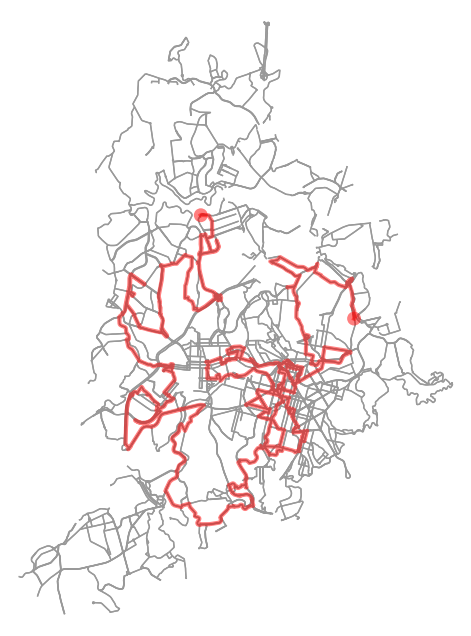

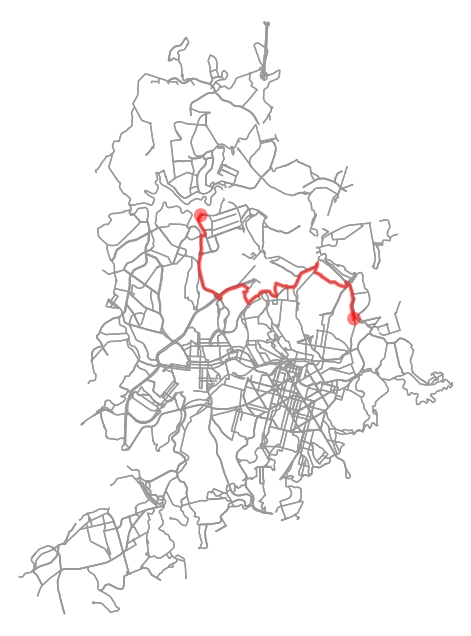

In [25]:
route = path_with_dfs(source_node, target_node, G)
fig, ax = ox.plot_graph_route(
    G, route, route_linewidth=3, node_size=0, bgcolor="white"
)
fig.savefig("dfs_route.png", dpi=300, bbox_inches="tight")  # Salva a figura exibida
plt.close(fig)  # Fecha a figura para evitar conflitos

route = path_with_astar(source_node, target_node, G)
fig, ax = ox.plot_graph_route(
    G, route, route_linewidth=3, node_size=0, bgcolor="white"
)
fig.savefig("astar_route.png", dpi=300, bbox_inches="tight")  # Salva a figura exibida
plt.close(fig)  # Fecha a figura para evitar conflitos